In [1]:
import json
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rc('font',size=20,weight='normal') #,family='Times New Roman'
#plt.rcParams['text.usetex']=True

In [3]:
userid = "63ecba74-b6e3-4880-9cbf-53d522cf5b29" 
indicators = "S6274789,S6292362,S6275791"
factors_name = ['cumulative confirmed','cumulative cured','cumulative death']
startdate = "2020-01-20"
enddate = "2021-02-28"
url = '''https://www.windquant.com/qntcloud/data/edb?userid={}&indicators={}&startdate={}&enddate={}'''.format(userid,
                                                                                                               indicators,
                                                                                                               startdate,
                                                                                                               enddate)
response = requests.get(url)
data = json.loads(response.content.decode("utf-8"))
try:
    time_list = data["times"]
    value_list = data["data"]
    for i in range(len(time_list)):
        time_list[i] = time.strftime("%Y-%m-%d", time.localtime(time_list[i]/1000))
    result = pd.DataFrame(columns=factors_name, index = time_list)
    for i in range(len(factors_name)):
        result[factors_name[i]] = value_list[i]
    result.index=pd.to_datetime(result.index,format='%Y-%m-%d')
except Exception as e:
    print("server error")

In [4]:
def kernel_smooth(time_serie,bandwidth):
    smooth_result=[]
    for i in range(int(len(time_serie))):
        weights_vector=np.exp(-(np.arange(int(len(time_serie)))-i)**2/(2*bandwidth**2))
        smooth_result.append(sum(time_serie*weights_vector)/sum(weights_vector))
    return smooth_result

In [5]:
result['cumulative confirmed_smooth']=kernel_smooth(result['cumulative confirmed'],7)
result['cumulative cured_smooth']=kernel_smooth(result['cumulative cured'],7)
result['cumulative death_smooth']=kernel_smooth(result['cumulative death'],7)

In [6]:
R_Q=[0]
for i in range(1,result.shape[0]):
    R_Q.append((result['cumulative cured_smooth'][i]-result['cumulative cured_smooth'][i-1])+R_Q[-1]*(1-1/270))
result['R_Q']=pd.Series(R_Q,index=result.index)

In [7]:
result.to_csv('covid-19-data.csv',index=True,index_label='date')

In [8]:
data=pd.read_csv('covid-19-data.csv',index_col=0).loc['2020-08-15':'2020-12-12',:]
test=pd.read_csv('covid-19-data-20200815-20201212-serum data.csv',index_col=0)

In [9]:
data['Q']=data['cumulative confirmed_smooth']-data['cumulative cured_smooth']-data['cumulative death_smooth']
data['new death']=-data['cumulative death_smooth'].diff(-1)
data['new confirmed']=-data['cumulative confirmed_smooth'].diff(-1)
data['new cured']=-data['cumulative cured_smooth'].diff(-1)
data['eta']=data['new death']/data['Q']
data['phi']=data['new cured']/data['Q']

In [10]:
data['seroprevalence']=pd.Series(np.array(test['seroprevalence']),index=data.index)

In [11]:
N=332915074

In [12]:
data['S']=(1-data['seroprevalence'])*(N-data['cumulative death_smooth'])
data['Delta_S']=-data['S'].diff(-1)
data['X']=N-data['S']-data['cumulative death_smooth']-data['R_Q']-data['Q']

In [13]:
def beta_E(lambda_,R_A,R_Q,Delta_S,r,A,E,S):
    return (N*(lambda_*R_A+lambda_*R_Q-Delta_S))/((r*A+E)*S)

In [14]:
def beta_A(beta_E,r):
    return beta_E*r

In [15]:
def gamma(Delta_C,alpha,E,A):
    return (Delta_C-alpha*E)/A

In [16]:
def r(A,E):
    return (59*E)/(41*A)

In [17]:
def effective_R_t(theta,beta_A,beta_E,r,phi,alpha,S,N):
    return ((1-theta)*beta_A/(r+phi)+theta*beta_E/alpha)*S/N

In [18]:
def loss_function(A_0,E_0,theta,flag,lambda_=1/270,alpha=0.33333):
    A=[A_0]
    E=[E_0]
    R_A=[N-data['cumulative death_smooth'][0]-data['S'][0]-data['Q'][0]-data['R_Q'][0]-A_0-E_0]
    list_beta_E=[]
    list_beta_A=[]
    list_gamma=[]
    list_eta=[]
    list_phi=[]
    list_r=[]
    Q_from_A=[]
    Q_from_E=[]
    list_R_t=[]
    real_new_recovered_=[]
    real_new_infected=[]
    R_Q=[data['R_Q'][0]]
    R_D=[data['cumulative death_smooth'][0]]
    I_Q=[data['Q'][0]]
    for i in range(0,119):
        e_r=r(A[-1],E[-1])
        e_beta_E=beta_E(lambda_=lambda_,
                        R_A=N-data['cumulative death_smooth'][i]-data['S'][i]-data['Q'][i]-A[-1]-E[-1],
                        R_Q=data['R_Q'][i],
                        Delta_S=data['Delta_S'][i],
                        r=e_r,
                        A=A[-1],
                        E=E[-1],
                        S=data['S'][i])
        e_beta_A=beta_A(beta_E=e_beta_E,
                        r=e_r)
        e_gamma=gamma(Delta_C=data['new confirmed'][i],
                      alpha=alpha,
                      E=E[-1],
                      A=A[-1])
        e_phi=data['phi'][i]
        e_eta=data['eta'][i]
        R_t=effective_R_t(theta=theta,
                          beta_A=e_beta_A,
                          beta_E=e_beta_E,
                          r=e_r,
                          phi=e_phi,
                          alpha=alpha,
                          S=data['S'][i],
                          N=N)
        if (R_A[-1]>=0 and e_beta_E>=0 and e_beta_A>=0 and e_gamma>=0)==True:
            new_A=A[-1]+(1-theta)*(e_beta_A*A[-1]+e_beta_E*E[-1])*data['S'][i]/N-e_gamma*A[-1]-e_phi*A[-1]
            new_E=E[-1]+theta*(e_beta_A*A[-1]+e_beta_E*E[-1])*data['S'][i]/N-alpha*E[-1]
            new_R_A=R_A[-1]+e_phi*A[-1]-lambda_*R_A[-1]
            if (new_A>=new_E)==True:
                R_Q.append(R_Q[-1]*(1-1/270)+e_phi*I_Q[-1])
                R_D.append(R_D[-1]+e_eta*I_Q[-1])
                I_Q.append(I_Q[-1]*(1-e_eta-e_phi)+e_gamma*A[-1]+E[-1]/3)
                Q_from_A.append(e_gamma*A[-1])
                Q_from_E.append(alpha*E[-1])
                A.append(new_A)
                E.append(new_E)
                R_A.append(new_R_A)
                list_R_t.append(R_t)
                list_r.append(e_r)
                list_beta_E.append(e_beta_E)
                list_beta_A.append(e_beta_A)
                list_gamma.append(e_gamma)
                list_phi.append(e_phi)
                list_eta.append(e_eta)
                real_new_recovered_.append(e_phi*A[-1])
                real_new_infected.append((e_beta_A*A[-1]+e_beta_E*E[-1])*data['S'][i]/N)
            else:
                return str(i)+' error!'
        else:
            return str(i)+' error!'
    membership_of_A=[]
    membership_of_X=[]
    X=np.array(A)+np.array(E)+np.array(R_A)
    for j in range(0,119):
        temp=Q_from_A[j]/(Q_from_A[j]+Q_from_E[j])
        if temp>=0.4 and temp<=0.6:
            membership_of_A.append(1)
        elif temp<0.4:
            membership_of_A.append(2.5*temp)
        else:
            membership_of_A.append(-2.5*temp+2.5)
        membership_of_X.append(max(1-abs((X[i+1]-data['X'][i+1])/data['X'][i+1]),0))
    if flag==1:
        return {'membership_of_A':sum(membership_of_A),
               'membership_of_X':sum(membership_of_X),
               'total_membership':sum(membership_of_A)+sum(membership_of_X)}
    if flag==0:
        dictionary={'membership_of_A':sum(membership_of_A),
                    'membership_of_X':sum(membership_of_X),
                    'total_membership':sum(membership_of_A)+sum(membership_of_X),
                    'A':A,
                    'E':E,
                    'R_A':R_A,
                    'Q_from_A':Q_from_A,
                    'Q_from_E':Q_from_E,
                    'list_beta_E':list_beta_E,
                    'list_beta_A':list_beta_A,
                    'list_gamma':list_gamma,
                    'list_phi':list_phi,
                    'list_eta':list_eta,
                    'list_r':list_r,
                    'list_R_t':list_R_t,
                    'real_new_recovered_':real_new_recovered_,
                    'real_new_infected':real_new_infected,
                    'R_Q':R_Q,
                    'R_D':R_D,
                    'I_Q':I_Q}
        return dictionary

In [19]:
def pattern_search(A_0,E_0,theta,step_A_0,step_E_0,step_theta,acceleration,shrink,epsilon):
    last_parameters_vector=np.array([A_0,E_0,theta])
    last_total_membership=loss_function(A_0=A_0,E_0=E_0,theta=theta,flag=1)['total_membership']
    while True:
        for i in range(3):
            if i==0:
                increment_A_0=step_A_0*(data['X'][0]/100)
                new_A_0=A_0+increment_A_0
                new_res=loss_function(A_0=new_A_0,E_0=E_0,theta=theta,flag=1)
                if type(new_res)==str:
                    while type(new_res)==str:
                        increment_A_0=increment_A_0/2
                        new_A_0=A_0+increment_A_0
                        new_res=loss_function(A_0=new_A_0,E_0=E_0,theta=theta,flag=1)
                new_total_membership=new_res['total_membership']
                if new_total_membership>last_total_membership:
                    A_0=new_A_0
                else:
                    increment_A_0=step_A_0*(data['X'][0]/100)
                    new_A_0=A_0-increment_A_0
                    new_res=loss_function(A_0=new_A_0,E_0=E_0,theta=theta,flag=1)
                    if type(new_res)==str:
                        while type(new_res)==str:
                            increment_A_0=increment_A_0/2
                            new_A_0=A_0-increment_A_0
                            new_res=loss_function(A_0=new_A_0,E_0=E_0,theta=theta,flag=1)
                    new_total_membership=new_res['total_membership']
                    if new_total_membership>last_total_membership:
                        A_0=new_A_0
                    else:
                        A_0=A_0
            if i==1:
                increment_E_0=step_E_0*(data['new confirmed'][0]/0.33333/100)
                new_E_0=E_0+increment_E_0
                new_res=loss_function(A_0=A_0,E_0=new_E_0,theta=theta,flag=1)
                if type(new_res)==str:
                    while type(new_res)==str:
                        increment_E_0=increment_E_0/2
                        new_E_0=E_0+increment_E_0
                        new_res=loss_function(A_0=A_0,E_0=new_E_0,theta=theta,flag=1)
                new_total_membership=new_res['total_membership']
                if new_total_membership>last_total_membership:
                    E_0=new_E_0
                else:
                    increment_E_0=step_E_0*(data['new confirmed'][0]/0.33333/100)
                    new_E_0=E_0-increment_E_0
                    new_res=loss_function(A_0=A_0,E_0=new_E_0,theta=theta,flag=1)
                    if type(new_res)==str:
                        while type(new_res)==str:
                            increment_E_0=increment_E_0/2
                            new_E_0=E_0-increment_E_0
                            new_res=loss_function(A_0=A_0,E_0=new_E_0,theta=theta,flag=1)
                    new_total_membership=new_res['total_membership']
                    if new_total_membership>last_total_membership:
                        E_0=new_E_0
                    else:
                        E_0=E_0
            if i==2:
                increment_theta=step_theta*0.1
                new_theta=theta+increment_theta
                new_res=loss_function(A_0=A_0,E_0=E_0,theta=new_theta,flag=1)
                if type(new_res)==str:
                    while type(new_res)==str:
                        increment_theta=increment_theta/2
                        new_theta=theta+increment_theta
                        new_res=loss_function(A_0=A_0,E_0=E_0,theta=new_theta,flag=1)
                new_total_membership=new_res['total_membership']
                if new_total_membership>last_total_membership:
                    theta=new_theta
                else:
                    increment_theta=step_theta*0.1
                    new_theta=theta-increment_theta
                    new_res=loss_function(A_0=A_0,E_0=E_0,theta=new_theta,flag=1)
                    if type(new_res)==str:
                        while type(new_res)==str:
                            increment_theta=increment_theta/2
                            new_theta=theta-increment_theta
                            new_res=loss_function(A_0=A_0,E_0=E_0,theta=new_theta,flag=1)
                    new_total_membership=new_res['total_membership']
                    if new_total_membership>last_total_membership:
                        theta=new_theta
                    else:
                        theta=theta
        current_parameters_vector=np.array([A_0,E_0,theta])
        current_total_membership=loss_function(A_0=A_0,E_0=E_0,theta=theta,flag=1)['total_membership']
        if current_total_membership>last_total_membership:
            direction_of_acceleration=current_parameters_vector-last_parameters_vector
            increment_acceleration=acceleration*direction_of_acceleration
            new_parameters_vector=current_parameters_vector+increment_acceleration
            last_parameters_vector=current_parameters_vector
            last_total_membership=current_total_membership
            A_0=new_parameters_vector[0]
            E_0=new_parameters_vector[1]
            theta=new_parameters_vector[2]
            new_res=loss_function(A_0=A_0,E_0=E_0,theta=theta,flag=1)
            if type(new_res)==str:
                while type(new_res)==str:
                    increment_acceleration=increment_acceleration/2
                    new_parameters_vector=current_parameters_vector+increment_acceleration
                    A_0=new_parameters_vector[0]
                    E_0=new_parameters_vector[1]
                    theta=new_parameters_vector[2]
                    new_res=loss_function(A_0=A_0,E_0=E_0,theta=theta,flag=1)
        else:
            norm_of_steps=step_A_0+step_E_0+step_theta
            if norm_of_steps<epsilon:
                return current_parameters_vector
            else:
                step_A_0=step_A_0*shrink
                step_E_0=step_E_0*shrink
                step_theta=step_theta*shrink
                A_0=last_parameters_vector[0]
                E_0=last_parameters_vector[1]
                theta=last_parameters_vector[2]

In [20]:
%%time

res=pattern_search(A_0=5000000,
                   E_0=100000,
                   theta=0.25,
                   step_A_0=25,
                   step_E_0=25,
                   step_theta=0.5,
                   acceleration=1.4,
                   shrink=0.3,
                   epsilon=0.00001)
res

Wall time: 16.9 s


array([1.11353077e+07, 7.29638924e+04, 2.22987987e-01])

In [21]:
dictionary=loss_function(A_0=res[0],
                         E_0=res[1],
                         theta=res[2],
                         flag=0)

In [22]:
dictionary['total_membership']

218.3798506278286

In [23]:
dictionary['membership_of_A']

107.70240147783798

In [24]:
dictionary['membership_of_X']

110.67744914999064

font = {'family':'SimHei','weight':'bold','size':25}

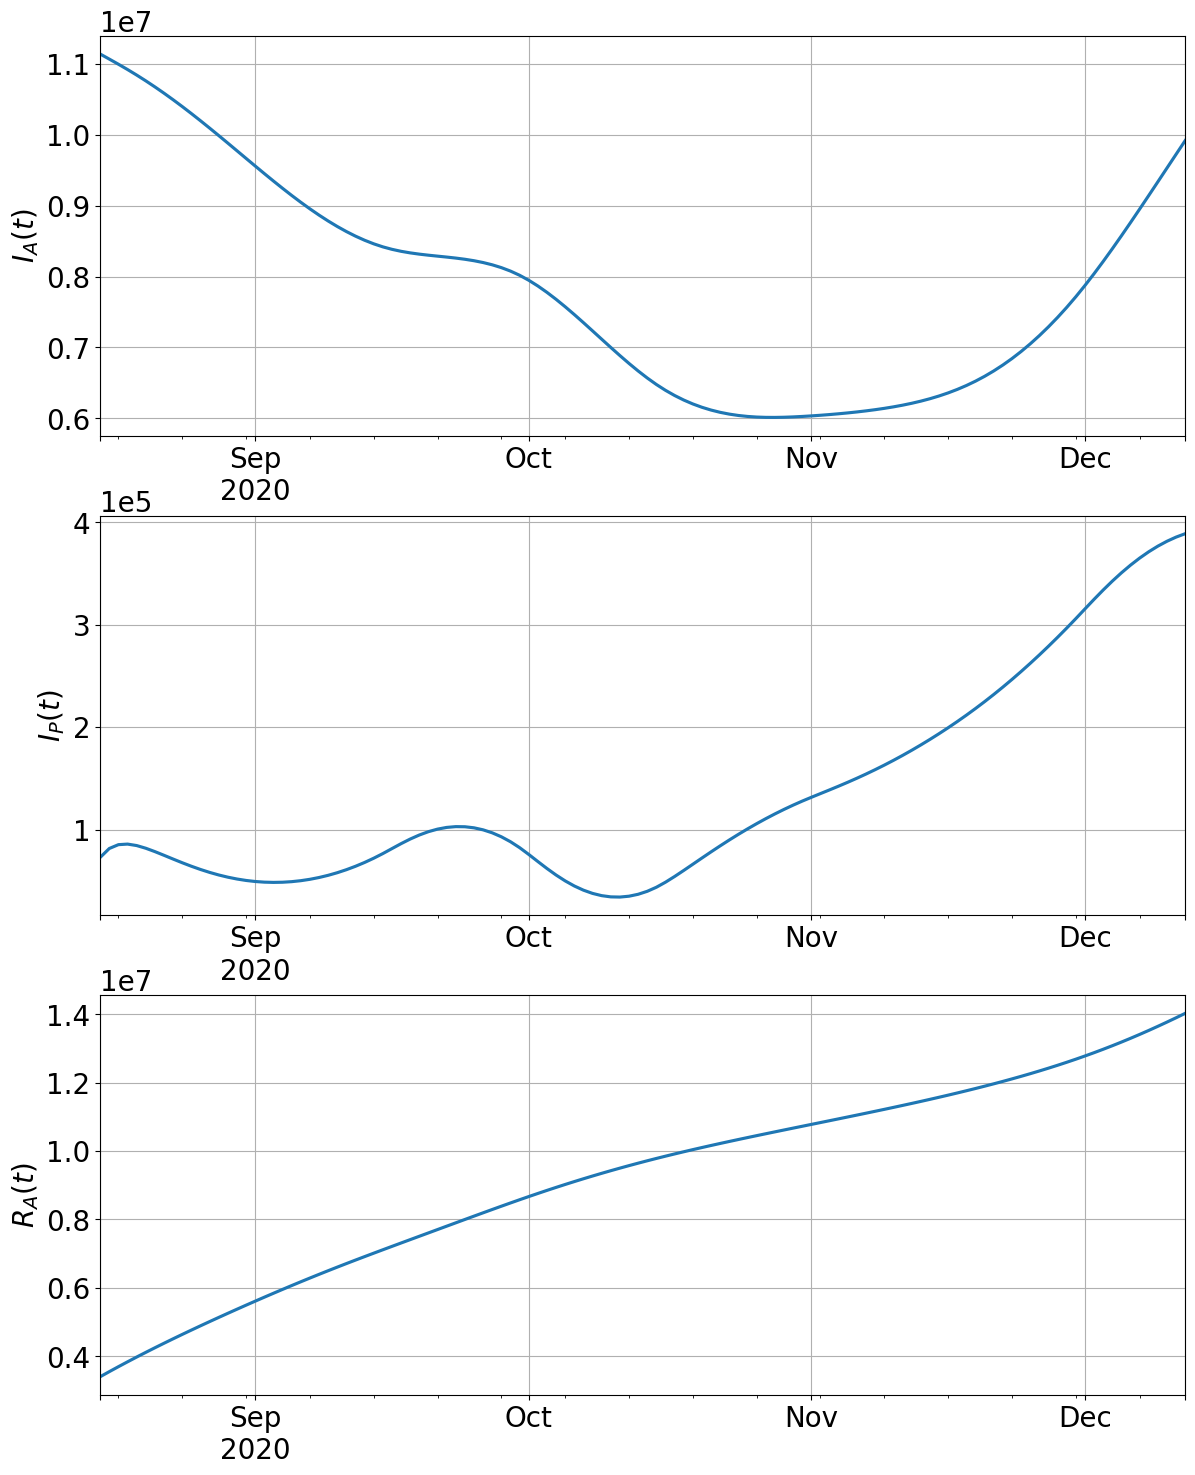

In [25]:
plt.figure(figsize=(14,18),dpi=100)

plt.subplot(311)
A_serie=pd.Series(dictionary['A'],index=pd.date_range(start='2020-08-15',end='2020-12-12'))
A_serie.plot(linewidth=2.25)
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
plt.ylabel(r'$I_A(t)$')
plt.grid()

plt.subplot(312)
E_serie=pd.Series(dictionary['E'],index=pd.date_range(start='2020-08-15',end='2020-12-12'))
E_serie.plot(linewidth=2.25)
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
plt.ylabel(r'$I_P(t)$')
plt.grid()

plt.subplot(313)
R_A_serie=pd.Series(dictionary['R_A'],index=pd.date_range(start='2020-08-15',end='2020-12-12'))
R_A_serie.plot(linewidth=2.25)
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
plt.ylabel(r'$R_A(t)$')
plt.grid()

plt.savefig('A&E&R_A.png',dpi=100,bbox_inches='tight')
plt.show()

In [26]:
pd.Series(dictionary['R_A'],index=pd.date_range(start='2020-08-15',end='2020-12-12'))

2020-08-15    3.403194e+06
2020-08-16    3.551403e+06
2020-08-17    3.696488e+06
2020-08-18    3.838649e+06
2020-08-19    3.978068e+06
                  ...     
2020-12-08    1.352659e+07
2020-12-09    1.364697e+07
2020-12-10    1.377051e+07
2020-12-11    1.389702e+07
2020-12-12    1.402630e+07
Freq: D, Length: 120, dtype: float64

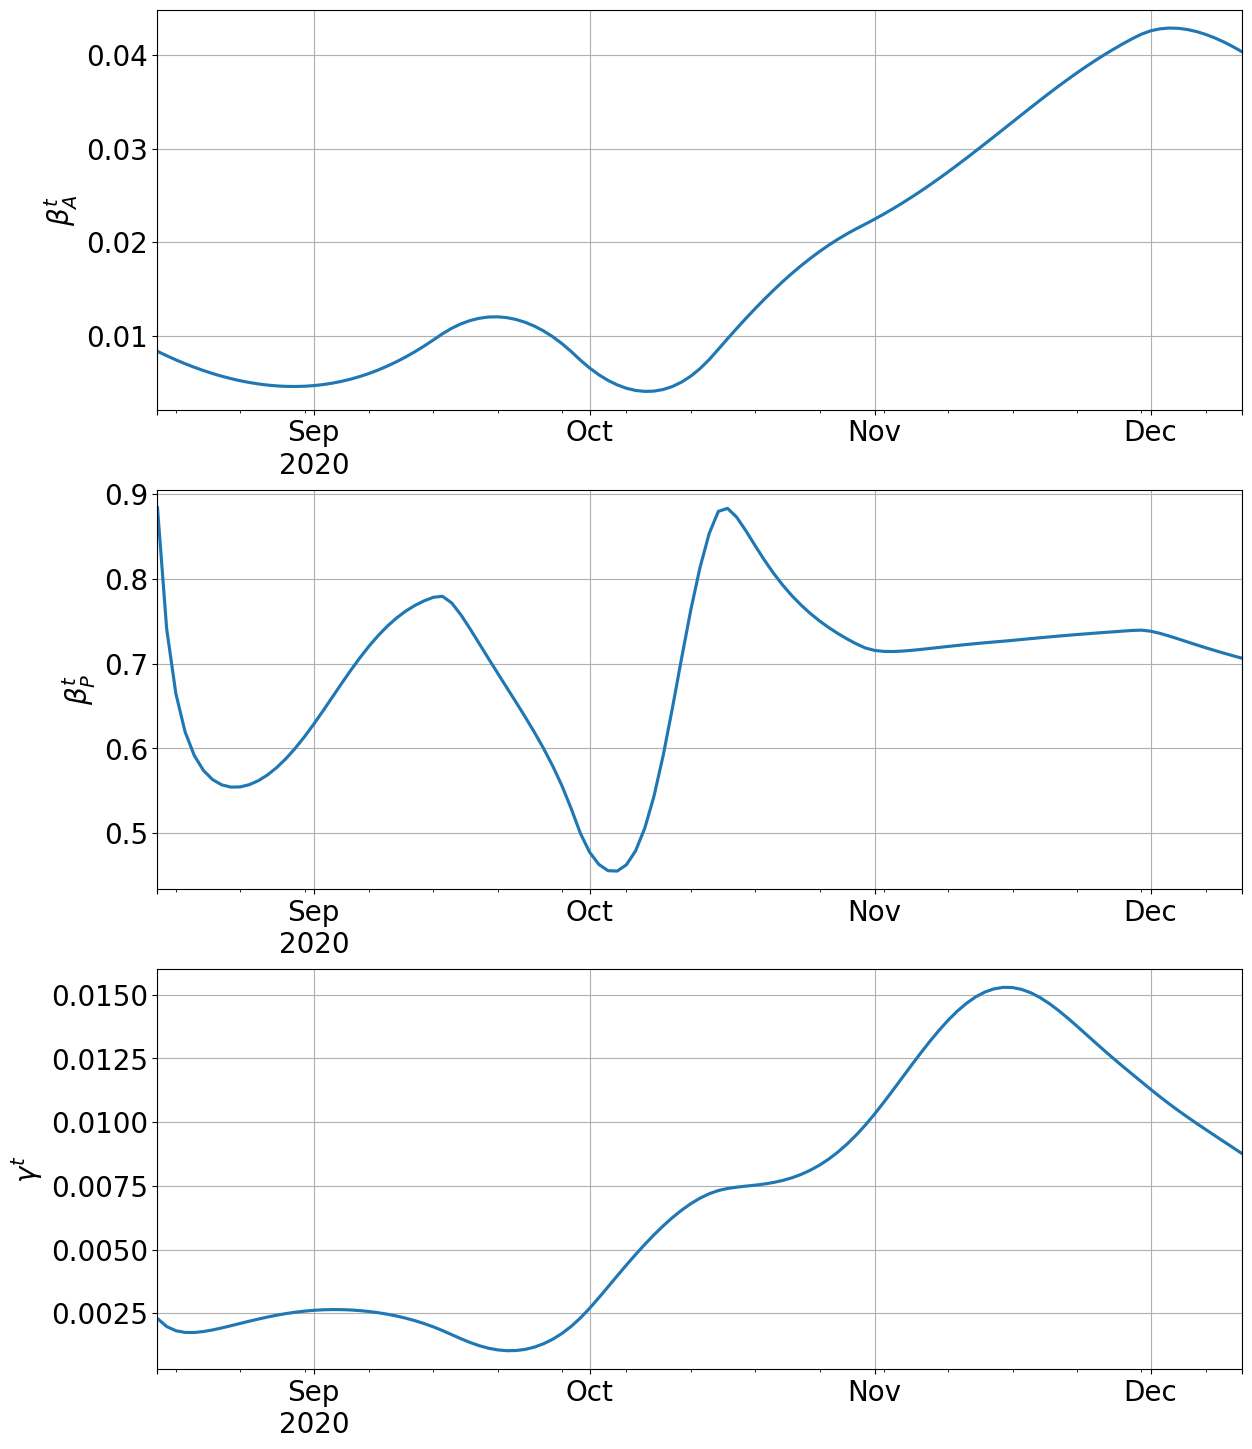

In [27]:
plt.figure(figsize=(14,18),dpi=100)

plt.subplot(311)
beta_A_serie=pd.Series(dictionary['list_beta_A'],
                       index=pd.date_range(start='2020-08-15',end='2020-12-11'))
beta_A_serie.plot(linewidth=2.25)
plt.ylabel(r'$\beta_A^t$')
plt.grid()

plt.subplot(312)
beta_E_serie=pd.Series(dictionary['list_beta_E'],
                       index=pd.date_range(start='2020-08-15',end='2020-12-11'))
beta_E_serie.plot(linewidth=2.25)
plt.ylabel(r'$\beta_P^t$')
plt.grid()

plt.subplot(313)
gamma_serie=pd.Series(dictionary['list_gamma'],
                              index=pd.date_range(start='2020-08-15',end='2020-12-11'))
gamma_serie.plot(linewidth=2.25)
plt.ylabel(r'$\gamma^t$')
plt.grid()

plt.savefig('parameters_1.png',dpi=100,bbox_inches='tight')
plt.show()

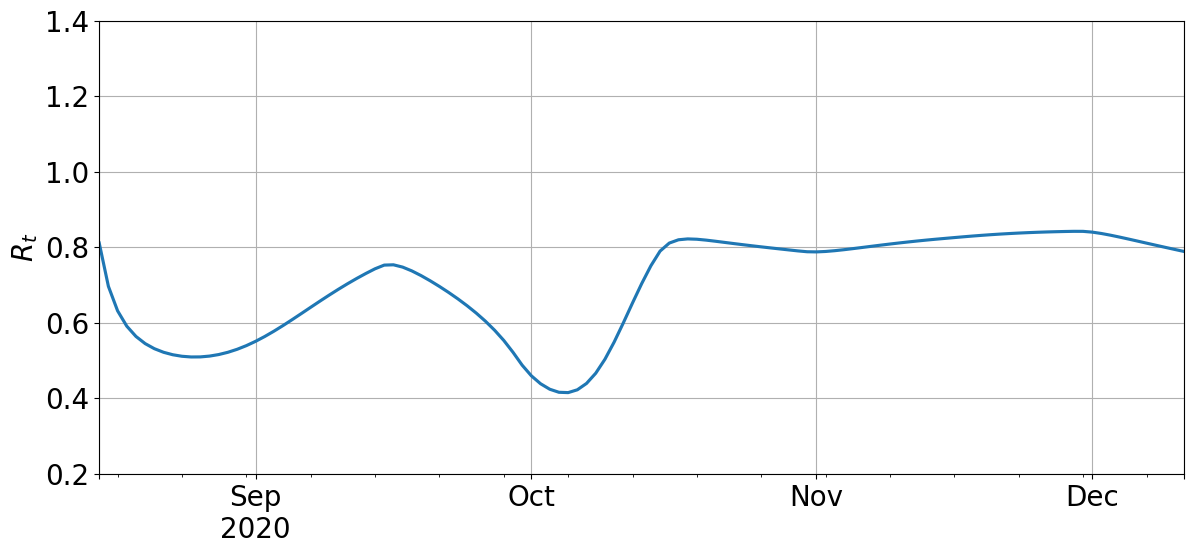

In [28]:
plt.figure(figsize=(14,6),dpi=100)

plt.subplot(111)
effective_R_t_serie=pd.Series(dictionary['list_R_t'],
                              index=pd.date_range(start='2020-08-15',end='2020-12-11'))
effective_R_t_serie.plot(linewidth=2.25)
plt.ylabel(r'$R_t$')
plt.ylim(0.2,1.4)
plt.grid()

plt.savefig('r_t.png',dpi=100,bbox_inches='tight')
plt.show()

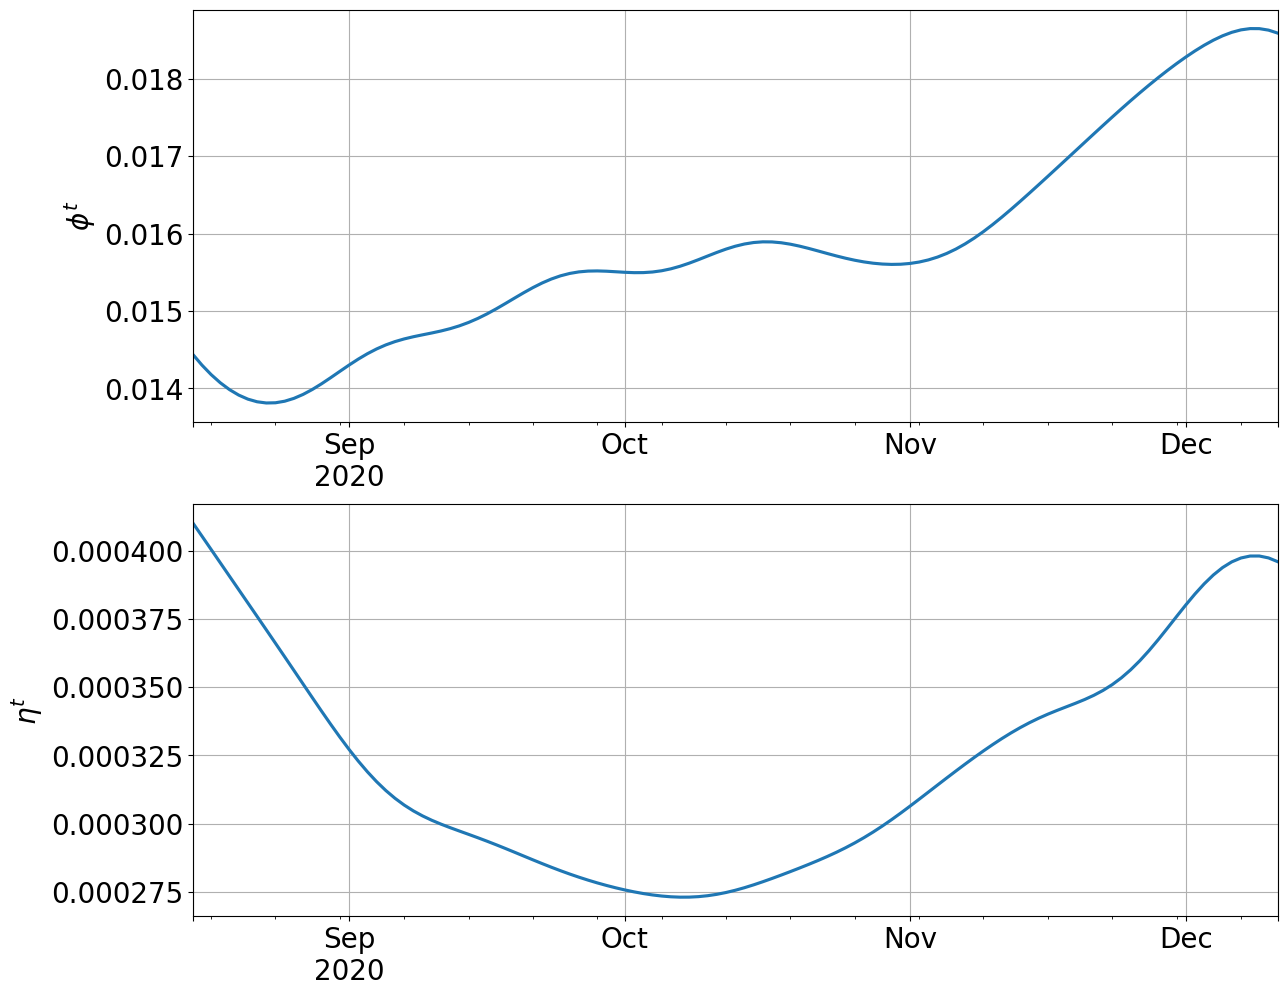

In [29]:
plt.figure(figsize=(14,12),dpi=100)

plt.subplot(211)
phi_serie=pd.Series(dictionary['list_phi'],
                              index=pd.date_range(start='2020-08-15',end='2020-12-11'))
phi_serie.plot(linewidth=2.25)
plt.ylabel(r'$\phi^t$')
plt.grid()

plt.subplot(212)
eta_serie=pd.Series(dictionary['list_eta'],
                              index=pd.date_range(start='2020-08-15',end='2020-12-11'))
eta_serie.plot(linewidth=2.25)
plt.ylabel(r'$\eta^t$')
plt.grid()

plt.savefig('parameters_2.png',dpi=100,bbox_inches='tight')
plt.show()

In [30]:
AER_A=np.array(dictionary['A'])+np.array(dictionary['E'])+np.array(dictionary['R_A'])

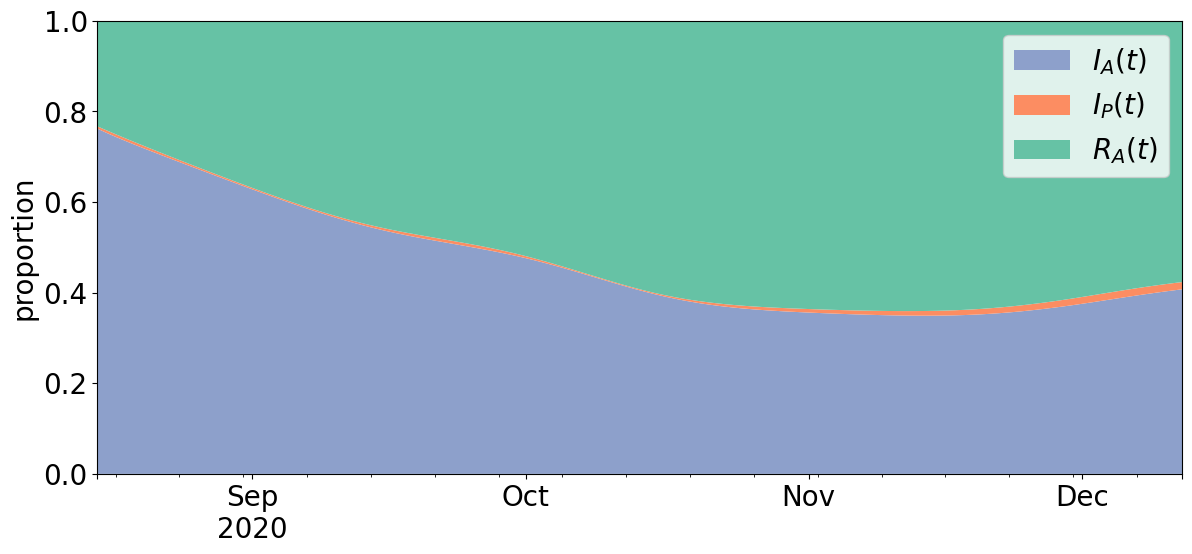

In [31]:
plt.figure(figsize=(14,6),dpi=100)

plt.subplot(111)

temp=pd.Series(index=pd.date_range(start='2020-08-15',end='2020-12-12'))
temp.plot()

labels = [r'$I_A(t)$',r'$I_P(t)$',r'$R_A(t)$']
colors = ['#8da0cb','#fc8d62','#66c2a5']
new_fig=plt.stackplot(pd.date_range(start='2020-08-15',end='2020-12-12'),
              np.array(dictionary['A'])/AER_A,
              np.array(dictionary['E'])/AER_A,
              np.array(dictionary['R_A'])/AER_A,
              labels=labels,
              colors=colors)
plt.ylim(0,1)
plt.ylabel('proportion')
plt.legend(new_fig,[r'$I_A(t)$',r'$I_P(t)$',r'$R_A(t)$'],loc='upper right')

plt.savefig('proportion.png',dpi=100,bbox_inches='tight')
plt.show()

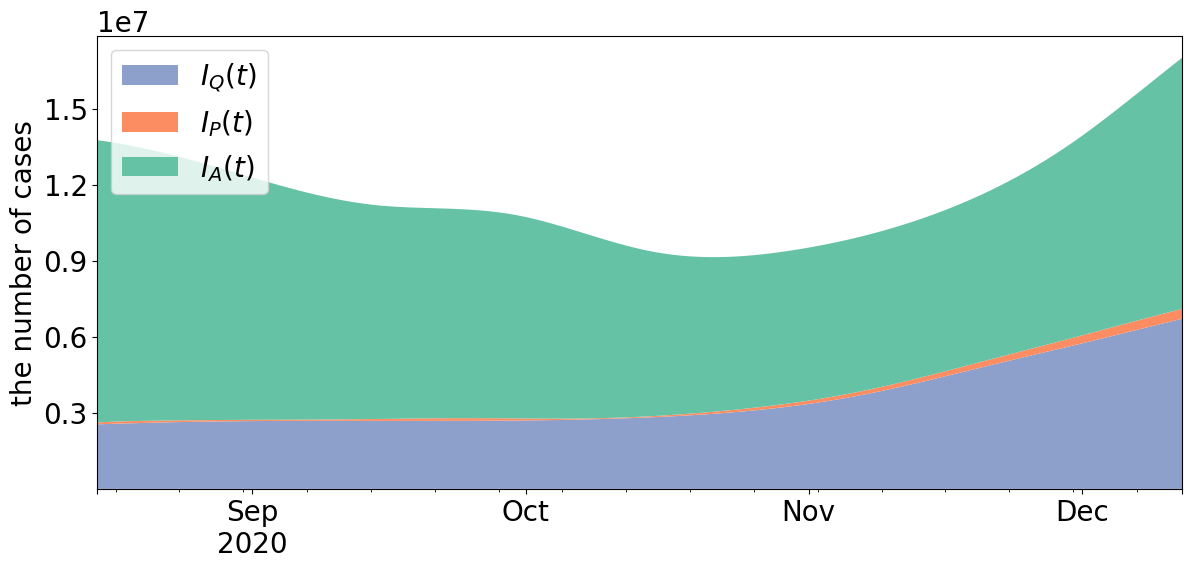

In [32]:
plt.figure(figsize=(14,6),dpi=100)

plt.subplot(111)

temp=pd.Series(index=pd.date_range(start='2020-08-15',end='2020-12-12'))
temp.plot()

labels = [r'$I_Q(t)$',r'$I_P(t)$',r'$I_A(t)$']
colors = ['#8da0cb','#fc8d62','#66c2a5']

new_fig1=plt.stackplot(pd.date_range(start='2020-08-15',end='2020-12-12'),
              data['Q'].values,
              dictionary['E'],
              dictionary['A'],
              labels=labels,
              colors=colors)
plt.yticks([3000000,6000000,9000000,12000000,15000000])
plt.ylabel('the number of cases')
plt.legend(new_fig1,[r'$I_Q(t)$',r'$I_P(t)$',r'$I_A(t)$'],loc='upper left')

plt.savefig('the number of cases.png',dpi=100,bbox_inches='tight')
plt.show()

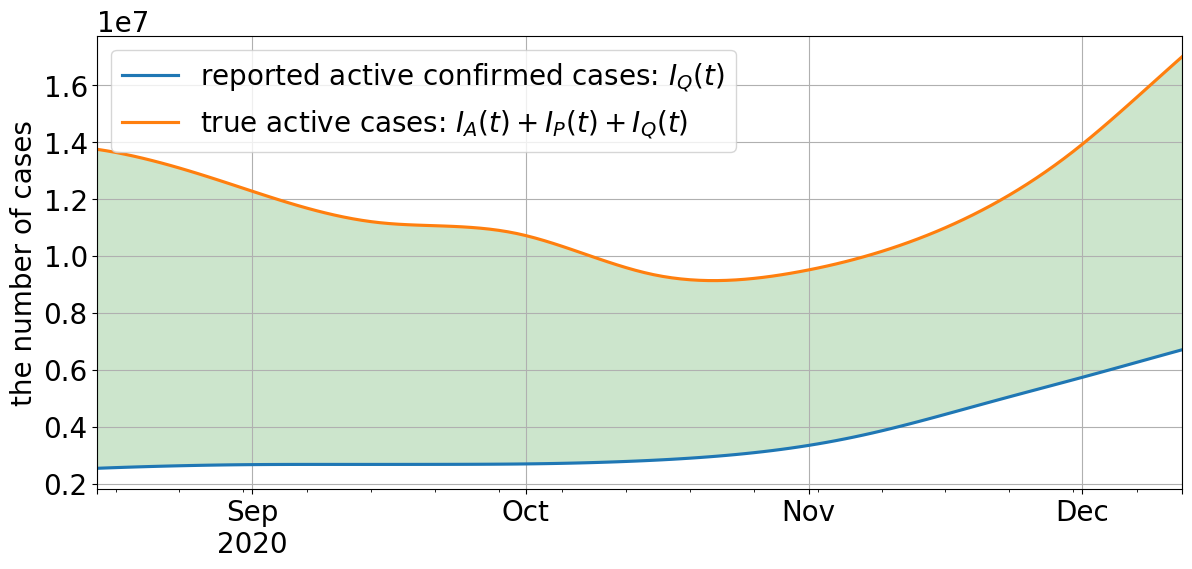

In [33]:
plt.figure(figsize=(14,6),dpi=100)

ac_serie=pd.Series(data['Q'].values,
                              index=pd.date_range(start='2020-08-15',end='2020-12-12'))
atc_serie=pd.Series(np.array(dictionary['E'])+np.array(dictionary['A'])+data['Q'].values,
                              index=pd.date_range(start='2020-08-15',end='2020-12-12'))
ac_serie.plot(linewidth=2.25,label=r'reported active confirmed cases: $I_Q(t)$')
atc_serie.plot(linewidth=2.25,label=r'true active cases: $I_A(t)+I_P(t)+I_Q(t)$')

plt.fill_between(np.array([i for i in range(18489,18609)]),data['Q'].values 
                 ,np.array(dictionary['E'])+np.array(dictionary['A'])+data['Q'].values,
                 facecolor='green', alpha=0.2)
plt.legend(loc='upper left')
plt.grid()
#plt.text(18529,6500000,'unconfirmed active cases')
plt.ylabel('the number of cases')
plt.savefig('active cases.png',dpi=100,bbox_inches='tight')
plt.show()

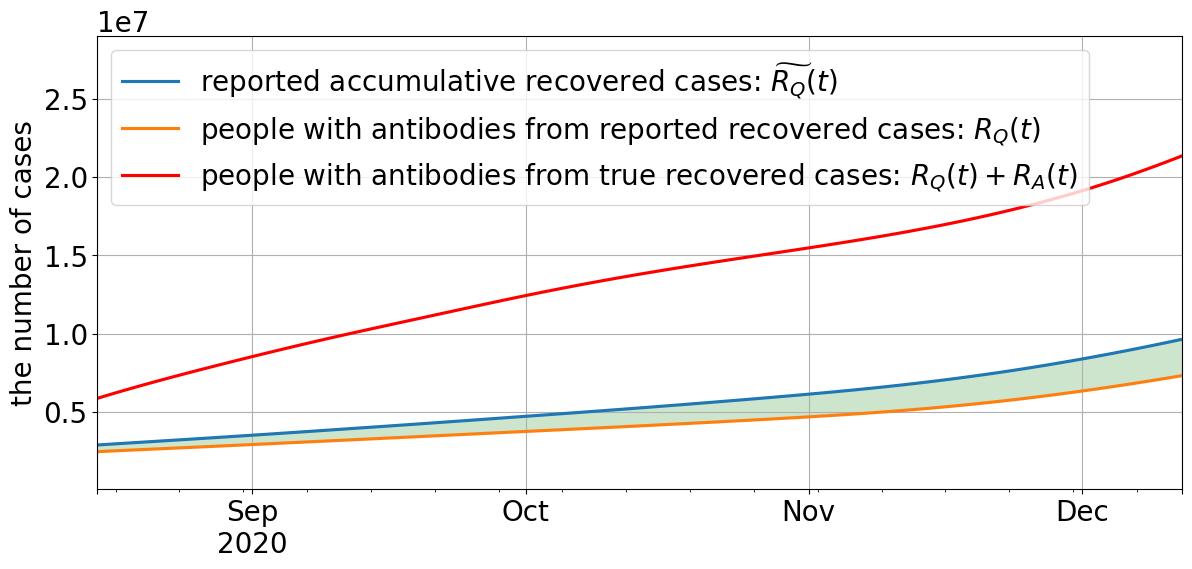

In [34]:
plt.figure(figsize=(14,6),dpi=100)

ac_serie=pd.Series(data['cumulative cured_smooth'].values,
                              index=pd.date_range(start='2020-08-15',end='2020-12-12'))
atc_serie=pd.Series(data['R_Q'].values,index=pd.date_range(start='2020-08-15',end='2020-12-12'))
attc_serie=pd.Series(data['R_Q'].values+np.array(dictionary['R_A']),index=pd.date_range(start='2020-08-15',end='2020-12-12'))

ac_serie.plot(linewidth=2.25,label=r'reported accumulative recovered cases: $\widetilde{R_Q}(t)$')
atc_serie.plot(linewidth=2.25,label=r'people with antibodies from reported recovered cases: $R_Q(t)$')
attc_serie.plot(linewidth=2.25,label=r'people with antibodies from true recovered cases: $R_Q(t)+R_A(t)$',c='red')

plt.fill_between(np.array([i for i in range(18489,18609)]),data['R_Q'].values
                 ,data['cumulative cured_smooth'].values,
                 facecolor='green', alpha=0.2)
plt.legend(loc='upper left')
plt.ylim(100000,29000000)
plt.grid()
#lt.text(18529,6500000,'recovered cases losing the protection of antibodies')
plt.ylabel('the number of cases')
plt.savefig('recovered cases.png',dpi=100,bbox_inches='tight')
plt.show()

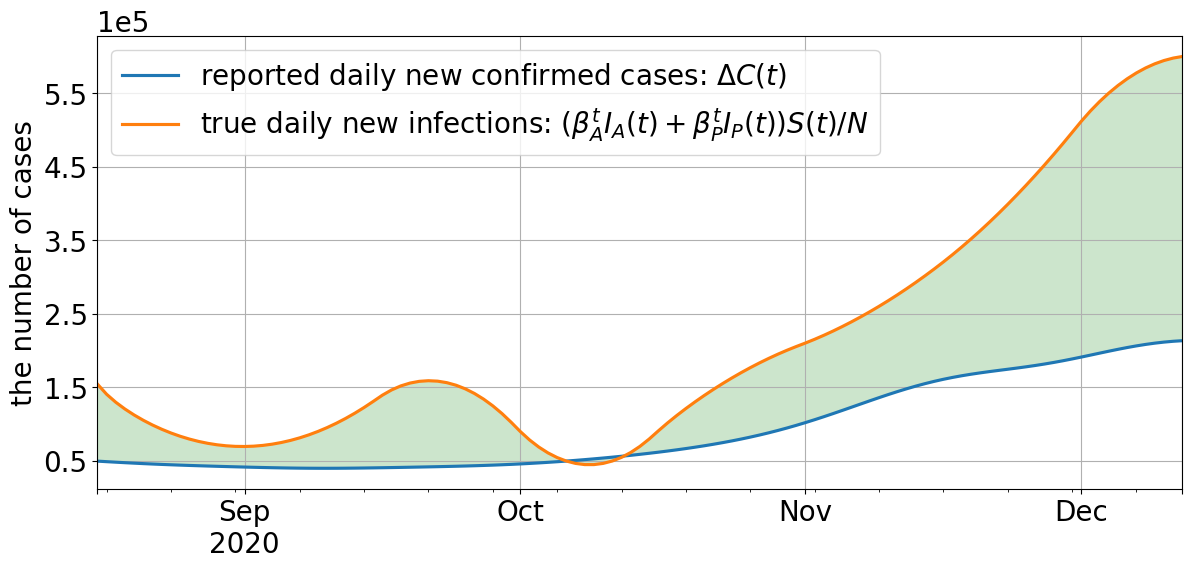

In [35]:
plt.figure(figsize=(14,6),dpi=100)

ac_serie=pd.Series(data['new confirmed'][:-1].values,
                              index=pd.date_range(start='2020-08-16',end='2020-12-12'))
atc_serie=pd.Series(dictionary['real_new_infected'],
                              index=pd.date_range(start='2020-08-16',end='2020-12-12'))
ac_serie.plot(linewidth=2.25,label=r'reported daily new confirmed cases: $\Delta C(t)$')
atc_serie.plot(linewidth=2.25,label=r'true daily new infections: $(\beta^t_AI_A(t)+\beta^t_PI_P(t))S(t)/N$')

plt.fill_between(np.array([i for i in range(18490,18609)]),data['new confirmed'][:-1].values
                 ,dictionary['real_new_infected'],
                 facecolor='green', alpha=0.2)

plt.yticks([50000,150000,250000,350000,450000,550000])

plt.ticklabel_format(style='sci', scilimits=(0,0),axis='y')

plt.legend(loc='upper left')
plt.grid()
plt.ylabel('the number of cases')
plt.savefig('daily infected cases.png',dpi=100,bbox_inches='tight')
plt.show()

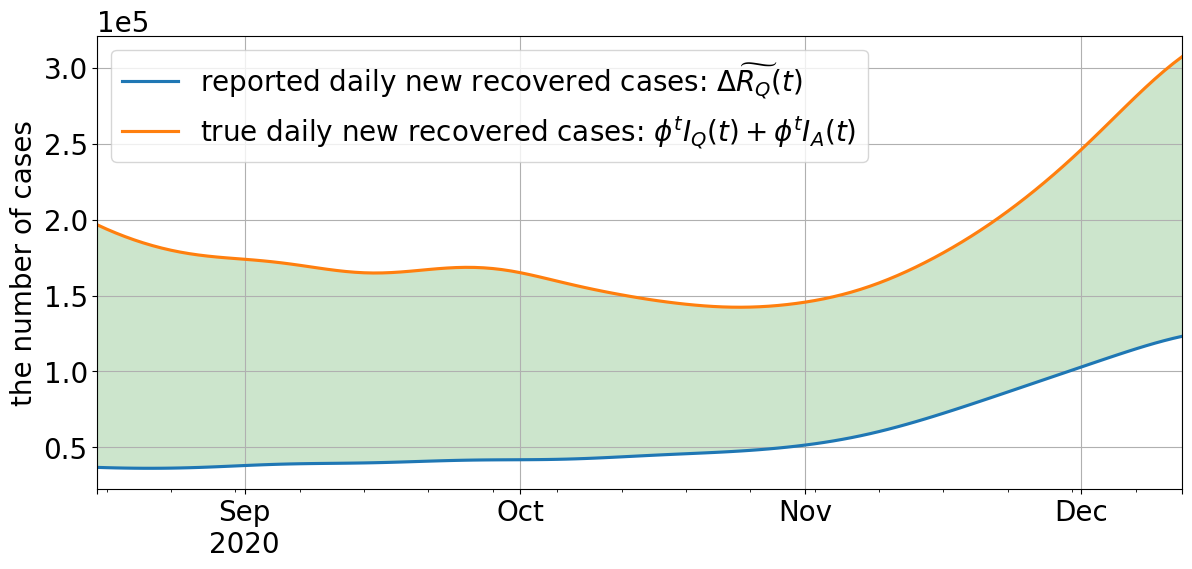

In [36]:
plt.figure(figsize=(14,6),dpi=100)

ac_serie=pd.Series(data['new cured'][:-1].values,
                              index=pd.date_range(start='2020-08-16',end='2020-12-12'))
atc_serie=pd.Series(np.array(dictionary['real_new_recovered_'])+data['new cured'][:-1].values,
                              index=pd.date_range(start='2020-08-16',end='2020-12-12'))
ac_serie.plot(linewidth=2.25,label=r'reported daily new recovered cases: $\Delta \widetilde{R_Q}(t)$')
atc_serie.plot(linewidth=2.25,label=r'true daily new recovered cases: $\phi^t I_Q(t)+\phi^t I_A(t)$')

plt.fill_between(np.array([i for i in range(18490,18609)]),data['new cured'][:-1].values
                 ,np.array(dictionary['real_new_recovered_'])+data['new cured'][:-1].values,
                 facecolor='green', alpha=0.2)

plt.ticklabel_format(style='sci', scilimits=(0,0),axis='y')

plt.legend(loc='upper left')
plt.grid()
plt.ylabel('the number of cases')
plt.savefig('daily recovered cases.png',dpi=100,bbox_inches='tight')
plt.show()